In [1]:
import sys
import time
import pyspark

In [2]:
sc.stop()
sleep_time = 30
time.sleep(sleep_time)

conf = pyspark.SparkConf().setAll([
                                   ('spark.driver.maxResultSize', '4g'), \
                                   ('spark.driver.memory','8g'),  \
                                   ('spark.num.executors', '32'),  \
                                ("spark.driver.maxResultSize", "4g"), \
                                   ('spark.cores.max','24'),  \
                                   ('spark.executor.memory', '10G'),  \
                                   ('spark.driver.maxResultSize', '3g'),  \
                                   ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),  \
                                   ('spark.kryoserializer.buffer.max', '256m'),  \
                                   ('spark.driver.cores', '3'),  \
                                  ])

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc).builder.getOrCreate()

24/05/21 04:45:52 WARN org.apache.spark.network.server.TransportChannelHandler: Exception in connection from /10.128.0.51:42870
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1133)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:148)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650)
	at io.netty.channel.nio.NioEventLoop.p

In [3]:
data_all = spark.read.parquet("gs://msca-bdp-data-open/news_similar/")
count_rows = data_all.count()

In [4]:
unique_languages = data_all.select("language").distinct()
unique_languages.show()

+--------+
|language|
+--------+
|      en|
+--------+



In [5]:
count_rows

100343

In [4]:
import pandas as pd
import numpy as np
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import StopWordsRemover # PySpark currently does not directly support automatic stop word lists for languages other than English
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as F

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 500)

In [7]:
data_all = data_all.withColumn("id", monotonically_increasing_id())
data_all = data_all.withColumn("title", lower(col("title")))\
        .withColumn("text", lower(col("text")))\
        .withColumn("title_words", split(col("title"), " "))\
        .withColumn("text_words", split(col("text"), " "))\
        .withColumn("title", lower(col("title")))\
        .withColumn("text", lower(col("text")))\
        .withColumn("title_words", F.regexp_replace(F.col("title_words"), "[^a-zA-Z0-9\\s]", " "))\
        .withColumn("text_words", F.regexp_replace(F.col("text_words"), "[^a-zA-Z0-9\\s]", " "))\
        .withColumn("clean_title", split(F.col("title_words"), " "))\
        .withColumn("clean_text", split(F.col("text_words"), " "))\
        .withColumn("cleaned_title", F.expr("filter(clean_title, word -> length(word) >= 3 and length(word) <= 45)"))\
        .withColumn("cleaned_text", F.expr("filter(clean_text, word -> length(word) >= 3 and length(word) <= 45)"))

remover_text_all = StopWordsRemover(inputCol="cleaned_text", outputCol="filtered_text_all")
remover_title = StopWordsRemover(inputCol="cleaned_title", outputCol="filtered_title")
remover_text = StopWordsRemover(inputCol="cleaned_text", outputCol="filtered_text")
data = data_all.limit(1000)
data = remover_title.transform(data)
data = remover_text.transform(data)
# data.limit(2)

In [10]:
final_ttl_df = data.select("id", "filtered_title")
final_txt_df = data.select("id", "filtered_text")

In [11]:
# display(final_ttl_df.limit(2).toPandas())
# display(final_txt_df.limit(2).toPandas())

In [8]:
def vectorize(df, input_col, output_col):
    vectorizer = CountVectorizer(inputCol=input_col, outputCol=output_col, minDF=1.0)
    return vectorizer.fit(df).transform(df)

def minhash_lsh(df, input_col, output_col, num_hash_tables=5):
    mh = MinHashLSH(inputCol=input_col, outputCol=output_col, numHashTables=num_hash_tables)
    model = mh.fit(df)
    return model, model.transform(df)

In [13]:
vectorize_ttl = vectorize(final_ttl_df, "filtered_title", "features_title")
vectorize_txt = vectorize(final_txt_df, "filtered_text", "features_text")
# display(vectorize_ttl.limit(5).toPandas())
# display(vectorize_txt.limit(5).toPandas())

In [14]:
model_ttl, df_hashed_ttl = minhash_lsh(vectorize_ttl, "features_title", "hashes_ttl" )
model_txt, df_hashed_txt = minhash_lsh(vectorize_txt, "features_text", "hashes_txt" )
# display(df_hashed_ttl.limit(5).toPandas())
# display(df_hashed_txt.limit(5).toPandas())

In [9]:
def find_dups(model, df, col_name, jaccard_distance=0.3):
    df_dups = model.approxSimilarityJoin(df, df, jaccard_distance) \
                       .filter("datasetA.id < datasetB.id") \
                       .select(
                           col("distCol"),
                           col("datasetA.id").alias("id_A"),
                           col("datasetB.id").alias("id_B"),
                           col(f'datasetA.filtered_{col_name}').alias(f'{col_name}_A'),
                           col(f'datasetB.filtered_{col_name}').alias(f'{col_name}_B'))
    return df_dups

# Duplicate Titles - Limit 1000

In [16]:
df_ttl_30 = find_dups(model_ttl, df_hashed_ttl, 'title', 0.3)
dups_ttl_30 = df_ttl_30.select('id_A').distinct().count()
uniques_ttl_30 = 1000 - dups_ttl_30
df_ttl_50 = find_dups(model_ttl, df_hashed_ttl, 'title', 0.5)
dups_ttl_50 = df_ttl_50.select('id_A').distinct().count()
uniques_ttl_50 = 1000 - dups_ttl_50
df_ttl_80 = find_dups(model_ttl, df_hashed_ttl, 'title', 0.8)
dups_ttl_80 = df_ttl_80.select('id_A').distinct().count()
uniques_ttl_80 = 1000 - dups_ttl_80

24/05/08 20:14:13 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 33.0 (TID 83) (hub-msca-bdp-dphub-students-dema-sw-jh4j.c.msca-bdp-students.internal executor 4): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3900/1468337917: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:224)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.c

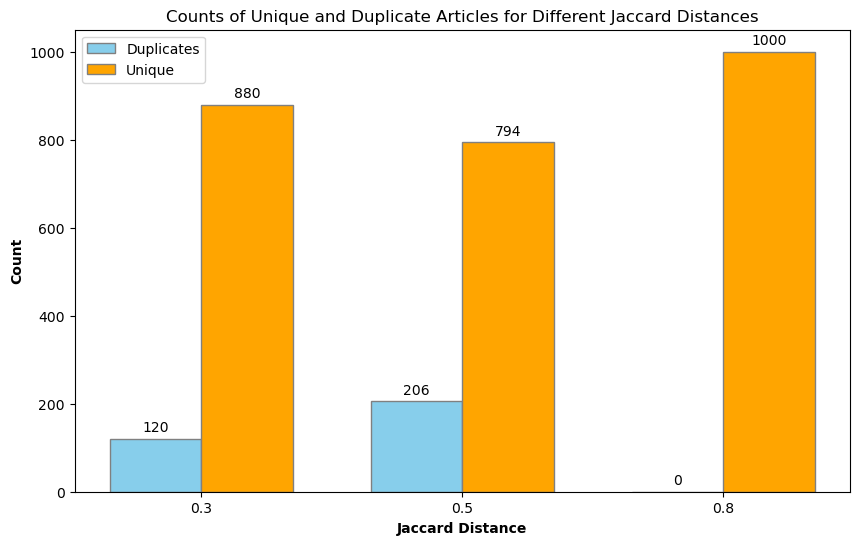

In [17]:
import matplotlib.pyplot as plt

jaccard_distances = [0.3, 0.5, 0.8]
duplicate_counts = [dups_ttl_30, dups_ttl_50, dups_ttl_80]
unique_counts = [uniques_ttl_30, uniques_ttl_50, uniques_ttl_80]
plt.figure(figsize=(10, 6))
bar_width = 0.35
r1 = range(len(jaccard_distances))
r2 = [x + bar_width for x in r1]
bars1 = plt.bar(r1, duplicate_counts, color='skyblue', width=bar_width, edgecolor='grey', label='Duplicates')
bars2 = plt.bar(r2, unique_counts, color='orange', width=bar_width, edgecolor='grey', label='Unique')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
plt.xlabel('Jaccard Distance', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(jaccard_distances))], jaccard_distances)
plt.ylabel('Count', fontweight='bold')
plt.legend()
plt.title('Counts of Unique and Duplicate Articles for Different Jaccard Distances')
plt.show()

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Duplicate Text - Limit 1000

In [18]:
df_txt_30 = find_dups(model_txt, df_hashed_txt, 'text', 0.3)
dups_txt_30 = df_txt_30.select('id_A').distinct().count()
uniques_txt_30 = 1000 - dups_txt_30
df_txt_50 = find_dups(model_txt, df_hashed_txt, 'text', 0.5)
dups_txt_50 = df_txt_50.select('id_A').distinct().count()
uniques_txt_50 = 1000 - dups_txt_50
df_txt_80 = find_dups(model_txt, df_hashed_txt, 'text', 0.8)
dups_txt_80 = df_txt_80.select('id_A').distinct().count()
uniques_txt_80 = 1000 - dups_txt_80

24/05/08 20:14:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1228.4 KiB
24/05/08 20:14:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1411.7 KiB
24/05/08 20:14:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1228.4 KiB
24/05/08 20:14:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1411.7 KiB
24/05/08 20:15:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1228.4 KiB
24/05/08 20:15:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1411.7 KiB


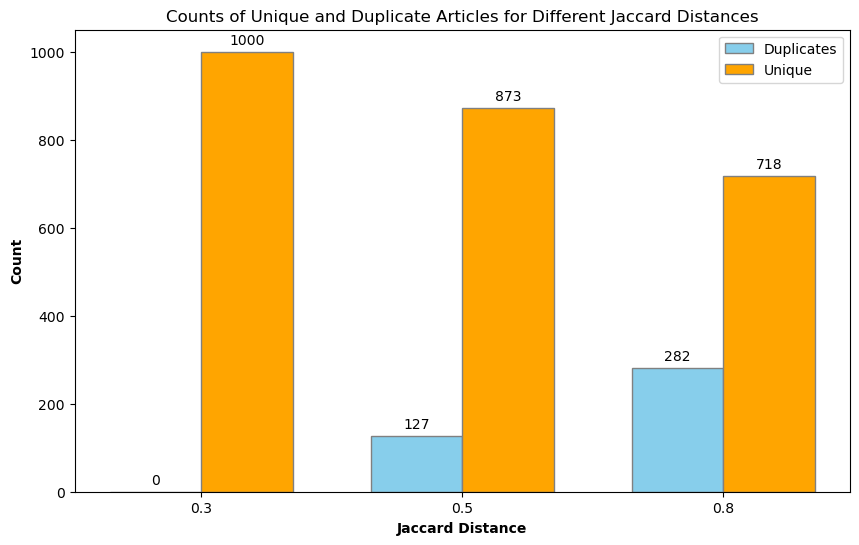

In [19]:
import matplotlib.pyplot as plt

jaccard_distances = [0.3, 0.5, 0.8]
duplicate_counts = [dups_txt_30, dups_txt_50, dups_txt_80]
unique_counts = [uniques_txt_30, uniques_txt_50, uniques_txt_80]
plt.figure(figsize=(10, 6))
bar_width = 0.35
r1 = range(len(jaccard_distances))
r2 = [x + bar_width for x in r1]
bars1 = plt.bar(r1, duplicate_counts, color='skyblue', width=bar_width, edgecolor='grey', label='Duplicates')
bars2 = plt.bar(r2, unique_counts, color='orange', width=bar_width, edgecolor='grey', label='Unique')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
plt.xlabel('Jaccard Distance', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(jaccard_distances))], jaccard_distances)
plt.ylabel('Count', fontweight='bold')
plt.legend()
plt.title('Counts of Unique and Duplicate Articles for Different Jaccard Distances')
plt.show()

24/05/08 20:16:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1228.1 KiB
24/05/08 20:16:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1406.3 KiB


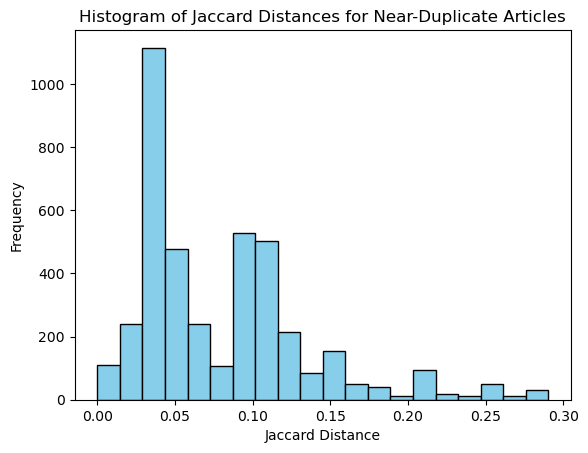

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(df_dups, bins=20):
    jaccard_distances = df_dups.select('distCol').rdd.flatMap(lambda x: x).collect()
    plt.hist(jaccard_distances, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Jaccard Distance')
    plt.ylabel('Frequency')
    plt.title('Histogram of Jaccard Distances for Near-Duplicate Articles')
    plt.show()

plot_histogram(df_txt_30)  

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Based on the results of running Locality Sensitive Hashing (LSH) on 1000 samples, I opted to utilize text only instead of incorporating both text and title to identify duplicates of the bid dataset below. When employing a Jaccard distance of 0.3, the analysis revealed that utilizing titles alone resulted in 912 unique instances, with 88 duplicates. However, focusing solely on text data yielded 895 unique entries with 105 duplicates. Moreover, when applying a less stringent Jaccard distance of 0.8, the disparity between the two approaches became more pronounced. Employing only titles led to 555 unique occurrences and 445 duplicates, while concentrating solely on text produced 188 unique instances and 812 duplicates.

These findings suggest that employing text alone provides a more efficient means of identifying duplicates. While doing both makes sense as well, focusing solely on text simplifies the process and reduces computational complexity. 

Further, since the goal of this assignemnt is to determine how many of these English articles are unique vs. how many are “near-duplicates”, a jaccard distance such as 0.3 could be sufficient to allow some degree of similarity. 

In [10]:
data_all = remover_text_all.transform(data_all)
data_all.limit(2)

url,date,language,title,text,id,title_words,text_words,clean_title,clean_text,cleaned_title,cleaned_text,filtered_text_all
http://idrw.org/g...,2021-01-26,en,govt to continue ...,govt to continue ...,17179869184,govt to continue...,govt to continue...,"[, govt, to, cont...","[, govt, to, cont...","[govt, continue, ...","[govt, continue, ...","[govt, continue, ..."
http://usweekly.c...,2021-06-03,en,tiktok bee-f? tik...,tiktok bee-f? tik...,17179869185,tiktok bee f ti...,tiktok bee f ti...,"[, tiktok, bee, f...","[, tiktok, bee, f...","[tiktok, bee, tik...","[tiktok, bee, tik...","[tiktok, bee, tik..."


In [11]:
df = data_all.select("id", "filtered_text_all") 

In [12]:
final_df = df.sample(withReplacement=False, fraction=0.1, seed=42)

In [13]:
count_rows_f = final_df.count()

In [14]:
vectorize_final = vectorize(final_df, "filtered_text_all", "features_text_all")

In [15]:
model_final, df_hashed_final = minhash_lsh(vectorize_final, "features_text_all", "hashes_txt_all" )

In [16]:
final_30 = find_dups(model_final, df_hashed_final, 'text_all', 0.3)

In [17]:
dups_final = final_30.select('id_A').distinct().count()

24/05/21 04:47:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/21 04:48:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/21 04:51:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/21 04:51:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [18]:
uniques_final = count_rows_f - dups_final

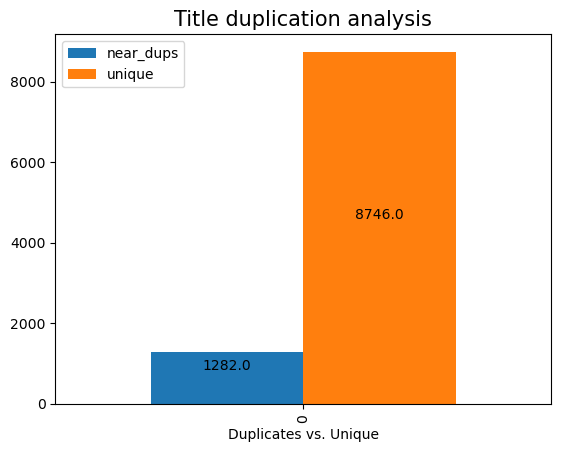

In [19]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_final], 'unique': [uniques_final]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

24/05/21 04:52:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/21 04:53:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/21 04:56:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


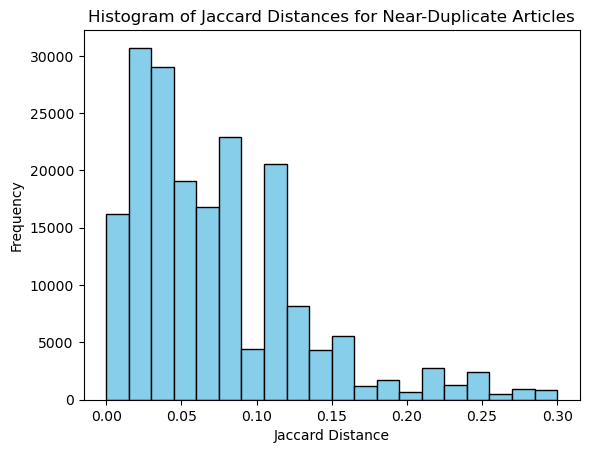

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(df_dups, bins=20):
    jaccard_distances = df_dups.select('distCol').rdd.flatMap(lambda x: x).collect()
    plt.hist(jaccard_distances, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Jaccard Distance')
    plt.ylabel('Frequency')
    plt.title('Histogram of Jaccard Distances for Near-Duplicate Articles')
    plt.show()
plot_histogram(final_30)